# Introduction

This notebook presents **bag-of-words** sentiment anlysis on [IMDB](http://ai.stanford.edu/~amaas/data/sentiment/) movie reviews dataset in Keras.

**Contents**

* [IMDB Dataset](#IMDB-Dataset) - load and preprocess
* [Keras Model](#Keras-Model) - build and train model

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Limit TensorFlow GPU memory usage

In [2]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config):
    pass  # init sessin with allow_growth

# IMDB Dataset

Load IMDB movie review dataset using Keras API. Most params are set to default values.

In [3]:
(x_train_raw, y_train), (x_test_raw, y_test) = tf.keras.datasets.imdb.load_data(
    path='imbd.npz',  # download to '~/.keras/datasets/' + path
    num_words=1000,   # top most frequent words to consider
    skip_top=0,       # top most frequent words to ignore ('the', 'a', 'at', ...)
    maxlen=None,      # truncate reviews longer than this
    seed=113,         # data shuffling seed
    start_char=1,     # start-of-sequence token
    oov_char=2,       # if skip_top used, then dropped words replaced with this token
    index_from=3)     # actual word tokens start here

Data shapes

In [4]:
print(x_train_raw.shape)
print(x_test_raw.shape)

(25000,)
(25000,)


Example data sample

In [5]:
print('Label:', y_train[0])
print('Review:', x_train_raw[0])

Label: 1
Review: [1, 14, 22, 16, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 2, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


Convert movie reviews to multi-hot vectors of length 1000, where each position corresponds to one word in vocabulary

In [6]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000)
x_train = tokenizer.sequences_to_matrix(x_train_raw, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test_raw, mode='binary')
x_train[0, :100]

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.])

# Keras Model

Simple multi-layer perceptron

In [7]:
from tensorflow.keras.layers import Dense
model = tf.keras.Sequential()
model.add(Dense(units=50, input_dim=1000, activation='sigmoid'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                50050     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,101
Trainable params: 50,101
Non-trainable params: 0
_________________________________________________________________


Keras only logs metrics every epoch, to get more datapoints we implement our own callback.

In [8]:
class Callback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accs = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accs.append(logs.get('acc'))

Train model

In [9]:
cback = Callback()
history = model.fit(x=x_train, y=y_train, batch_size=250, epochs=2, callbacks=[cback])

Epoch 1/2
25000/25000 [==============================] - 1s 36us/step - loss: 0.5392 - acc: 0.7789
Epoch 2/2
25000/25000 [==============================] - 0s 19us/step - loss: 0.3825 - acc: 0.8492


Final results

In [10]:
loss, acc = model.evaluate(x_train, y_train, verbose=0)
print(f'Accuracy on train set: {acc:.2f}')
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy on test set: {acc:.2f}')

Accuracy on train set: 0.86
Accuracy on test set: 0.85


Plot loss and accuracy during training period

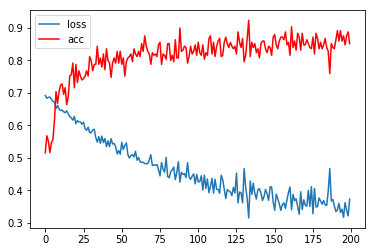

In [11]:
plt.plot(cback.losses, label='loss')
plt.plot(cback.accs, label='acc', color='red')
plt.legend();